###  Photosynthetic Electron Transport Chain mathematical model (version from 2014)
With this Notebook you can reproduce the results presented in 

Oliver Ebenhöh, Geoffrey Fucile, Giovanni Finazzi, Jean‐David Rochaix and Michel Goldschmidt‐Clermont (2014)
"Short-term acclimation of the photosynthetic electron transfer chain to changing light: a mathematical model"
*Phil Trans Roy Soc B* 369 doi:10.1098/rstb.2013.0223

The mathematical model of the photosynthetic electron transport chain has been implemented using the modelbase1.0 software developed at the University of Dusseldorf.

#### The model has been implemented using the modelbase1.0 version

In [1]:
# I want to have my figures active here (e.g., zoom into my plots)
%matplotlib notebook

Could not find GLIMDA.


<IPython.core.display.Javascript object>


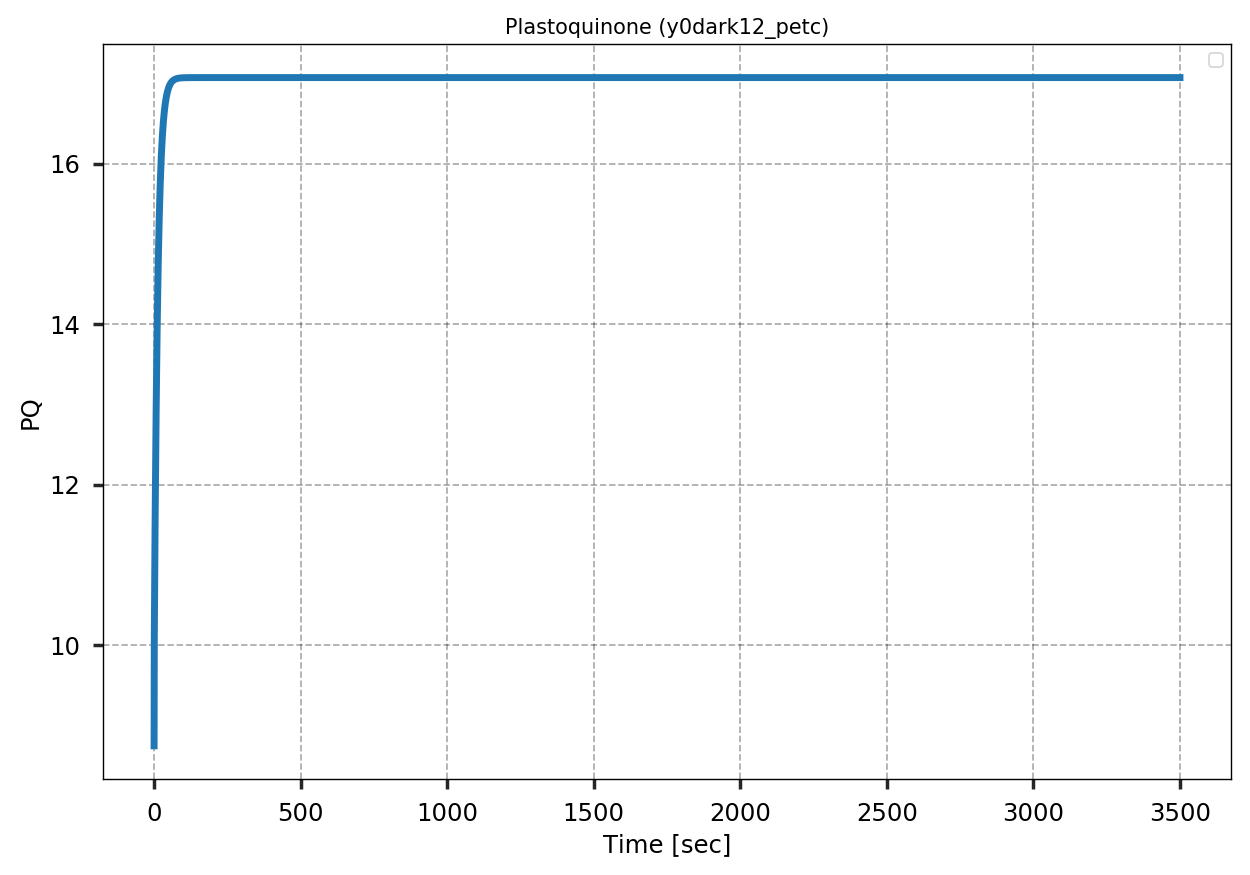

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


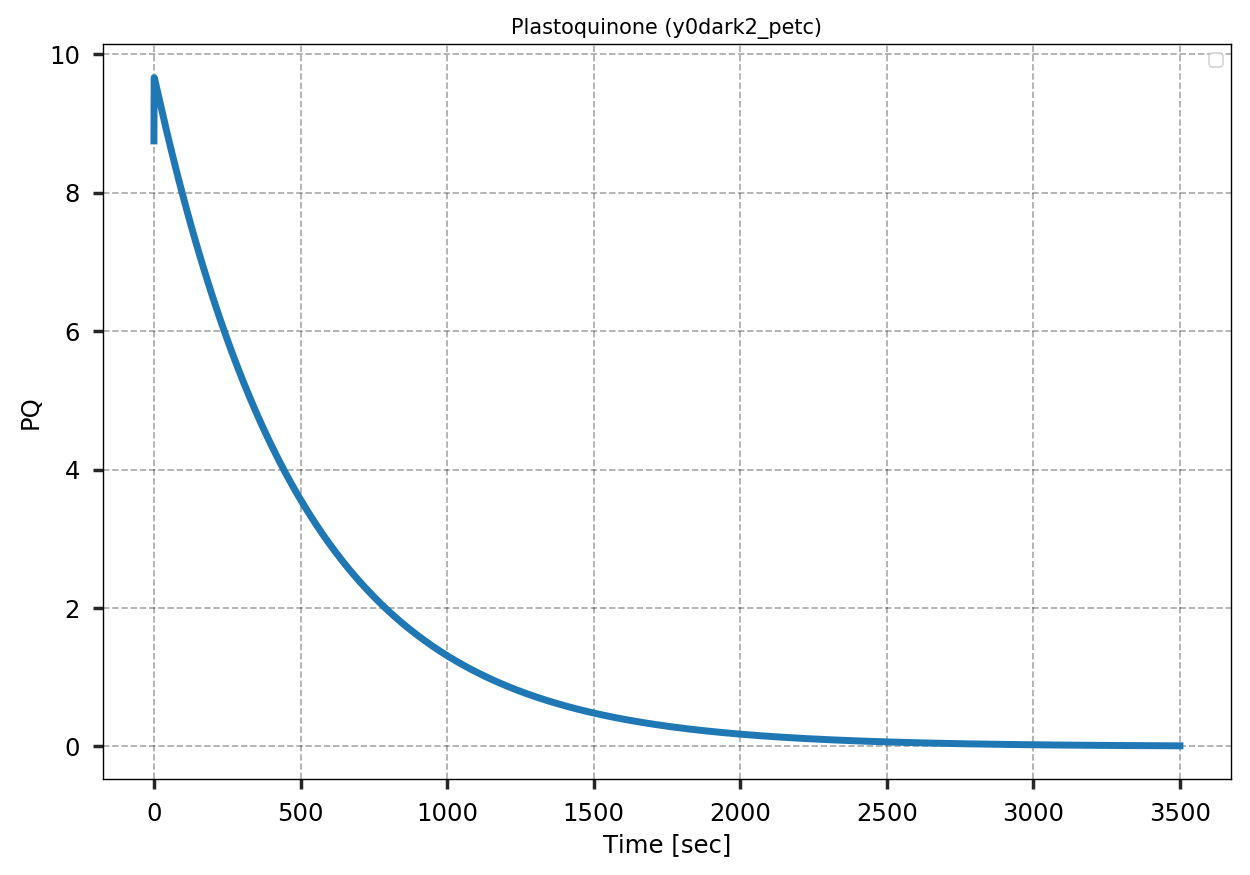

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


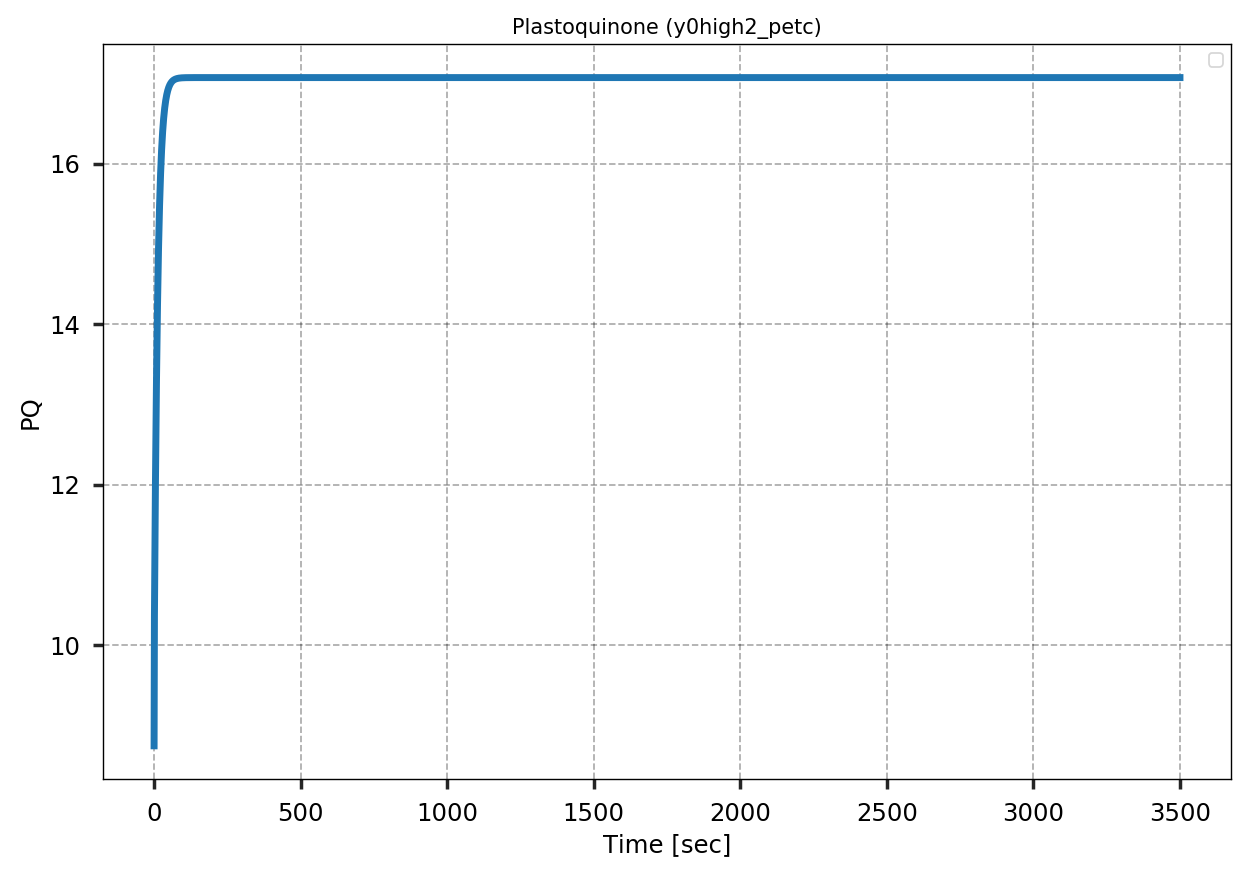

No handles with labels found to put in legend.


[8.84216151e-03 3.54569692e-06 4.99999973e+00 9.80356978e-09
 2.57943192e-12 1.92449005e-05 2.70840292e-01 4.50000000e-01
 4.50000000e-01]


In [2]:
from modelbase.ode import Model, Simulator

import numpy as np
import matplotlib.pyplot as plt

from y0_new_values_petc_longer import y0dark12_petc, y0dark2_petc, y0high2_petc

## Create the model

I start with defining the compound list, as this is how I am thinking about model's structure: state variabels that describe the dynamics od the system.

In [3]:
variables = [
        "PQ",  # oxidised plastoquinone
        "PC",  # oxidised plastocyan
        "Fd",  # oxidised ferrodoxin
        "ATP",  # stromal concentration of ATP
        "NADPH",  # stromal concentration of NADPH
        "H",  # lumenal protons
        "LHC", #non-phosphorylated LHC
        "Psbs",
        "Vx",
]

Next I pass the dictionary/dictionaries of parameters

p = {
    "PSIItot": 2.5, # [mmol/molChl] total concentration of PSII
    "PSItot": 2.5,
    "PQtot": 17.5, # [mmol/molChl]
    "PCtot": 4., # Bohme1987 but other sources give different values - seems to depend greatly on organism and conditions
    "Fdtot": 5., # Bohme1987
    "Ctot": 2.5, #source unclear (Schoettler says 0.4...?, but plausible to assume that complexes (PSII,PSI,b6f) have approx. same abundance)
    "NADPtot": 0.8, # estimate from ~ 0.8 mM, Heineke1991
    "APtot": 2.55, # [mmol/molChl] Bionumbers ~2.55mM (=81mmol/molChl) (FIXME: Soma had 50)
    "Psbstot": 1., # relative pool of PsbS
    "Xtot": 1., # relative pool of carotenoids (V+A+Z)
    #Mara "ATPasetot": 1., # relative pool of ATPase

    # parameters associated with photosystem II
    "kH": 5e9,
    "kH0": 5e8, # base quenching" after calculation with Giovanni
    "kF": 6.25e8, # 6.25e7 fluorescence 16ns
    "k1": 5e9, # excitation of Pheo / charge separation 200ps
    "k1rev": 1e10,
    "k2": 5e9,#Mara was 5e10 # original 5e9 (charge separation limiting step ~ 200ps) - made this faster for higher Fs fluorescence
    
    # parameters associated with photosystem I
    "kStt7": 0.0035, # [s-1] fitted to the FM dynamics
    "kPph1": 0.0013, # [s-1] fitted to the FM dynamics
    "KM_ST": 0.2, # Switch point (half-activity of Stt7) for 20% PQ oxidised (80% reduced)
    "n_ST": 2., # Hill coefficient of 4 -> 1/(2.5^4)~1/40 activity at PQox=PQred
    "staticAntI": 0.37,     # corresponds to PSI - LHCI supercomplex, when chlorophyll decreases more relative fixed antennae
    "staticAntII": 0.1,     # corresponds to PSII core


     # ATP and NADPH parameters
    #"kActATPase": 0.05,  # on 14.09 increased from 0.01 to saturate between 1-2 min, not 10
                            # paramter relating the rate constant of activation of the ATPase in the light
    #"kDeactATPase": 0.002,   # paramter relating the deactivation of the ATPase at night
    "kATPsynth": 20.,    # taken from MATLAB
    "kATPcons": 10.,     # taken from MATLAB
    "ATPcyt": 0.5,       # only relative levels are relevant (normalised to 1) to set equilibrium
    "Pi_mol": 0.01,
    "DeltaG0_ATP": 30.6, # 30.6kJ/mol / RT
    "HPR": 14./3.,  #Vollmar et al. 2009 (after Zhu et al. 2013)
    "kNADPHcons": 15., # taken from MATLAB
    "NADPHcyt": 0.5, # only relatice levels

    # global conversion factor of PFD to excitation rate
    #"cPFD": 4. # [m^2/mmol PSII]

    # pH and protons
    "pHstroma": 7.8,
    "kLeak": 10.,#0.010, # [1/s] leakage rate -- inconsistency with Kathrine
    "bH": 100., # proton buffer: ratio total / free protons

    # rate constants
    "kPQred": 250., # [1/(s*(mmol/molChl))]
    "kCytb6f": 2.5, # a rough estimate: transfer PQ->cytf should be ~10ms
    "kPTOX": .01, # ~ 5 electrons / seconds. This gives a bit more (~20)
    "kPCox": 2500., # a rough estimate: half life of PC->P700 should be ~0.2ms
    "kFdred": 2.5e5, # a rough estimate: half life of PC->P700 should be ~2micro-s
    "kcatFNR": 500., # Carrillo2003 (kcat~500 1/s)
    "kcyc": 1.,

    "O2ext": 8., # corresponds to 250 microM cor to 20%
    "kNDH": .002, # re-introduce e- into PQ pool. Only positive for anaerobic (reducing) condition
    "kNh": 0.05,
    "kNr": 0.004,
    "NPQsw": 5.8,
    "nH": 5.,

    "EFNR": 3., # Bohme1987
    "KM_FNR_F": 1.56, # corresponds to 0.05 mM (Aliverti1990)
    "KM_FNR_N": 0.22, # corresponds to 0.007 mM (Shin1971 Aliverti2004)

    # quencher fitted parameters
    "gamma0": 0.1,          # slow quenching of Vx present despite lack of protonation
    "gamma1": 0.25,         # fast quenching present due to the protonation
    "gamma2": 0.6,          # slow quenching of Zx present despite lack of protonation
    "gamma3": 0.15,         # fastest possible quenching

    # non-photochemical quenching PROTONATION
    "kDeprotonation": 0.0096,
    "kProtonationL": 0.0096,
    "kphSatLHC": 5.8,
    "nH": 5.,
    "NPQsw": 5.8,

    # non-photochemical quenching XANTOPHYLLS
    "kDeepoxV": 0.0024,
    "kEpoxZ": 0.00024,      # 6.e-4        # converted to [1/s]
    "kphSat": 5.8,          # [-] half-saturation pH value for activity de-epoxidase highest activity at ~pH 5.8
    "kHillX": 5.,     # [-] hill-coefficient for activity of de-epoxidase
    "kHillL": 3.,     # [-] hill-coefficient for activity of de-epoxidase
    "kZSat": 0.12,          # [-] half-saturation constant (relative conc. of Z) for quenching of Z

    # standard redox potentials (at pH=0) in V
    "E0_QA": -0.140,
    "E0_PQ": 0.354,
    "E0_cytf": 0.350,
    "E0_PC": 0.380,
    "E0_P700": 0.480,
    "E0_FA": -0.550,
    "E0_Fd": -0.430,
    "E0_NADP": -0.113,

    # physical constants
    "F": 96.485, # Faraday constant
    "R": 8.3e-3, # universal gas constant
    "T": 298., # Temperature in K - for now assumed to be constant at 25 C

    # light
    "pfd": 100.,
    "Ton": 0.,
    "Toff": 1800,
    "dT": 120,

    "ox": True, # 1. means True, switched on
    }

In [4]:
p = {"convf":3.2*10e-3, #converts ATP and NADPH
    "PSIItot": 2.5, # [mmol/molChl] total concentration of PSII
    "PSItot": 2.5,
    "PQtot": 17.5, # [mmol/molChl]
    "PCtot": 4., # Bohme1987 but other sources give different values - seems to depend greatly on organism and conditions
    "Fdtot": 5., # Bohme1987
    "Ctot": 2.5, #source unclear (Schoettler says 0.4...?, but plausible to assume that complexes (PSII,PSI,b6f) have approx. same abundance)
    "NADPtot": 0.8, # estimate from ~ 0.8 mM, Heineke1991
    "APtot": 2.55, # [mmol/molChl] Bionumbers ~2.55mM (=81mmol/molChl) (FIXME: Soma had 50)
    "Psbstot": 1., # relative pool of PsbS
    "Xtot": 1., # relative pool of carotenoids (V+A+Z)
    #Mara "ATPasetot": 1., # relative pool of ATPase

    # parameters associated with photosystem II
    "kH": 5e9,
    "kH0": 5e8, # base quenching" after calculation with Giovanni
    "kF": 6.25e8, # 6.25e7 fluorescence 16ns
    "k1": 5e9, # excitation of Pheo / charge separation 200ps
    "k1rev": 1e10,
    "k2": 5e9,#Mara was 5e10 # original 5e9 (charge separation limiting step ~ 200ps) - made this faster for higher Fs fluorescence
    "kdeg": 100,    # rate of PSII damage corresponds to p.k2 / .5e8
    "krep": 5.55e-4, # rate of repair fo PSII

    # parameters associated with photosystem I
    "kStt7": 0.0035, # [s-1] fitted to the FM dynamics
    "kPph1": 0.0013, # [s-1] fitted to the FM dynamics
    "KM_ST": 0.2, # Switch point (half-activity of Stt7) for 20% PQ oxidised (80% reduced)
    "n_ST": 2., # Hill coefficient of 4 -> 1/(2.5^4)~1/40 activity at PQox=PQred
    "staticAntI": 0.37,     # corresponds to PSI - LHCI supercomplex, when chlorophyll decreases more relative fixed antennae
    "staticAntII": 0.1,     # corresponds to PSII core
    "prob_attach": 1.,            # probability of antena attaching to PSI


     # ATP and NADPH parameters
    "kActATPase": 0.05,  # on 14.09 increased from 0.01 to saturate between 1-2 min, not 10
                            # paramter relating the rate constant of activation of the ATPase in the light
    "kDeactATPase": 0.002,   # paramter relating the deactivation of the ATPase at night
    "kATPsynth": 20.,    # taken from MATLAB
    "kATPcons": 10.,     # taken from MATLAB
    "ATPcyt": 0.5,       # only relative levels are relevant (normalised to 1) to set equilibrium
    "Pi_mol": 0.01,
    "DeltaG0_ATP": 30.6, # 30.6kJ/mol / RT
    "HPR": 14./3.,  #Vollmar et al. 2009 (after Zhu et al. 2013)
    "kNADPHcons": 15., # taken from MATLAB
    "NADPHcyt": 0.5, # only relatice levels

    # global conversion factor of PFD to excitation rate
    #"cPFD": 4. # [m^2/mmol PSII]

    # pH and protons
    "pHstroma": 7.8,
    "kLeak": 10.,#0.010, # [1/s] leakage rate -- inconsistency with Kathrine
    "bH": 100., # proton buffer: ratio total / free protons

    # rate constants
    "kPQred": 250., # [1/(s*(mmol/molChl))]
    "kCytb6f": 2.5, # a rough estimate: transfer PQ->cytf should be ~10ms
    "kPTOX": .01, # ~ 5 electrons / seconds. This gives a bit more (~20)
    "kPCox": 2500., # a rough estimate: half life of PC->P700 should be ~0.2ms
    "kFdred": 2.5e5, # a rough estimate: half life of PC->P700 should be ~2micro-s
    "kcatFNR": 500., # Carrillo2003 (kcat~500 1/s)
    "kcyc": 1.,

    "O2ext": 8., # corresponds to 250 microM cor to 20%
    "kNDH": .002, # re-introduce e- into PQ pool. Only positive for anaerobic (reducing) condition
    "kNh": 0.05,
    "kNr": 0.004,
    "NPQsw": 5.8,
    "nH": 5.,

    "EFNR": 3., # Bohme1987
    "KM_FNR_F": 1.56, # corresponds to 0.05 mM (Aliverti1990)
    "KM_FNR_N": 0.22, # corresponds to 0.007 mM (Shin1971 Aliverti2004)

    # quencher fitted parameters
    "gamma0": 0.1,          # slow quenching of Vx present despite lack of protonation
    "gamma1": 0.25,         # fast quenching present due to the protonation
    "gamma2": 0.6,          # slow quenching of Zx present despite lack of protonation
    "gamma3": 0.15,         # fastest possible quenching

    # non-photochemical quenching PROTONATION
    "kDeprotonation": 0.0096,
    "kProtonationL": 0.0096,
    "kphSatLHC": 5.8,
    "nH": 5.,
    "NPQsw": 5.8,

    # non-photochemical quenching XANTOPHYLLS
    "kDeepoxV": 0.0024,
    "kEpoxZ": 0.00024,      # 6.e-4        # converted to [1/s]
    "kphSat": 5.8,          # [-] half-saturation pH value for activity de-epoxidase highest activity at ~pH 5.8
    "kHillX": 5.,     # [-] hill-coefficient for activity of de-epoxidase
    "kHillL": 3.,     # [-] hill-coefficient for activity of de-epoxidase
    "kZSat": 0.12,          # [-] half-saturation constant (relative conc. of Z) for quenching of Z

    # standard redox potentials (at pH=0) in V
    "E0_QA": -0.140,
    "E0_PQ": 0.354,
    "E0_cytf": 0.350,
    "E0_PC": 0.380,
    "E0_P700": 0.480,
    "E0_FA": -0.550,
    "E0_Fd": -0.430,
    "E0_NADP": -0.113,

    # physical constants
    "F": 96.485, # Faraday constant
    "R": 8.3e-3, # universal gas constant
    "T": 298., # Temperature in K - for now assumed to be constant at 25 C

    # light
    "pfd": 100.,
    "Ton": 0.,
    "Toff": 1800,
    "dT": 120,

    "ox": True, # 1. means True, switched on
     
    # CBB cycle associated parameter set according to Pettersson and Pettersson 1988
    'CN': 0.5,
    'CO2': 0.2,
    'Cp': 15+2.05,#15.0
    'Ca': 0.5,
    'pHmedium': 7.6,
    'pHstroma': 7.9,
    'Pext': 0.5,

    #Vmaxes of Calvin cycle enzymes
    'V1': 0.34*8,
    'V6': 0.2*8,
    'V9': 0.04*8,
    'V13': 0.9999*8,
    'Vst': 0.04*8,
    'Vx': 0.25*8,

    #equilibrium constants of calvin cycle enzymes
    'q2': 3.1 * (10.0 ** (-4.0)),
    'q3': 1.6 * (10.0**7.0),
    'q4': 22.0,
    'q5': (7.1),
    'q7': 0.084,
    'q8': (13.0),
    'q10': 0.85,
    'q11': 0.4,
    'q12': 0.67,
    'q14': 2.3,
    'q15': 0.058,

    #michaelis constants of calvin cycle enzymes
    'Km1': 0.02,
    'KmCO2': 0.0107, #millimol laut witzel
    'Km6': 0.03,
    'Km9': 0.013,
    'Km131': 0.05,
    'Km132': 0.05,
    'Km161': 0.014,
    'Km162': 0.3,
    'Kmst1': 0.08,
    'Kmst2': 0.08,
    'Kmnadph': 0.19,#ausgerechneter wert (ideal wert)
    'Kpga': 0.25,
    'Kgap': 0.075,
    'Kdhap': 0.077,
    'Kpi': 0.63,
    'Kpxt': 0.74,
    'Ki11': 0.04,
    'Ki12': 0.04,
    'Ki13': 0.075,
    'Ki14': 0.9,
    'Ki15': 0.07,
    'Ki61': 0.7,
    'Ki62': 12.0,
    'Ki9': 12.0,
    'Ki131': 2.0,
    'Ki132': 0.7,
    'Ki133': 4.0,
    'Ki134': 2.5,
    'Ki135': 0.4,
    'Kist': 10.0,
    'Kast1': 0.1,
    'Kast2': 0.02,
    'Kast3': 0.02,

    'k': 10.0**8.0*8,
    'oxPPP': 0.
    }

### Here we define the model object

In [5]:
# modelbase 0.4.0
m = Model(parameters=p, compounds=variables)

In [6]:
m.get_compounds()

['PQ', 'PC', 'Fd', 'ATP', 'NADPH', 'H', 'LHC', 'Psbs', 'Vx']

From now on we will be adding various components to the model, such as derived parameters, that can be calculated from the provided parameters, derived variables, which can be calculated from other variables and reactions.

In [7]:
# ====================================================================== #
# Composed parameters #
m.add_derived_parameter(
    parameter_name="RT", function=lambda r, t: r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="dG_pH", function=lambda r, t: np.log(10) * r * t, parameters=["R", "T"]
)

m.add_derived_parameter(
    parameter_name="Hstroma", function=lambda pHstroma: 3.2e4*10**(-pHstroma), parameters=["pHstroma"]
)

m.add_derived_parameter(
    parameter_name="kProtonation", function=lambda Hstroma: 4e-3 / Hstroma, parameters=["Hstroma"]
)

def keq_PQred(E0_QA, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_QA * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * pHstroma * dG_pH
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PQred", function=keq_PQred, parameters=["E0_QA", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)

def Keq_cyc(E0_Fd, F, E0_PQ, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_PQ * F
    DG = -2 * DG1 + DG2 + 2 * dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_cyc", function=Keq_cyc, parameters=["E0_Fd", "F", "E0_PQ", "pHstroma", "dG_pH", "RT"]
)              

def Keq_FAFd(E0_FA, F, E0_Fd, RT):
    DG1 = -E0_FA * F
    DG2 = -E0_Fd * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K
               
m.add_derived_parameter(
    parameter_name="Keq_FAFd", function=Keq_FAFd, parameters=["E0_FA", "F", "E0_Fd", "RT"]
)               

def Keq_PCP700(E0_PC, F, E0_P700, RT):
    DG1 = -E0_PC * F
    DG2 = -E0_P700 * F
    DG = -DG1 + DG2
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_PCP700", function=Keq_PCP700, parameters=["E0_PC", "F", "E0_P700", "RT"]
)               

def Keq_FNR(E0_Fd, F, E0_NADP, pHstroma, dG_pH, RT):
    DG1 = -E0_Fd * F
    DG2 = -2 * E0_NADP * F
    DG = -2 * DG1 + DG2 + dG_pH * pHstroma
    K = np.exp(-DG/RT)
    return K

m.add_derived_parameter(
    parameter_name="Keq_FNR", function=Keq_FNR, parameters=["E0_Fd", "F", "E0_NADP", "pHstroma", "dG_pH", "RT"]
) 

def Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)
    Keq = Pi_mol * np.exp(-DG/RT)
    return Keq

def Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    DG1 = -2 * F * E0_PQ
    DG2 = -F * E0_PC
    DG = - (DG1 + 2*dG_pH * pH) + 2 * DG2 + 2*dG_pH * (pHstroma - pH)
    Keq = np.exp(-DG/RT)
    return Keq


In [8]:
def calculate_pHstroma(x):
    return (-np.log(x*(3.2e-5))/np.log(10))    

def calculate_pHinv(x):
    return (4e3*10**(-x))

def light(pfd):
    '''
    :return: light intensity at certain point of time. 
    Typical PAM light function
    '''
    return pfd

In [9]:
def pqmoiety(PQ, pqtot):
    return pqtot - PQ

m.add_algebraic_module(
    module_name="pq_alm",
    function=pqmoiety,
    compounds=["PQ"],
    derived_compounds=["PQred"],
    modifiers=None,
    parameters=["PQtot"],
)

def pcmoiety(PC, pctot):
    return pctot - PC

m.add_algebraic_module(
    module_name="pc_alm",
    function=pcmoiety,
    compounds=["PC"],
    derived_compounds=["PCred"],
    parameters=["PCtot"],
)

def fdmoiety(Fd, fdtot):
    return fdtot - Fd

m.add_algebraic_module(
    module_name="fd_alm",
    function=fdmoiety,
    compounds=["Fd"],
    derived_compounds=["Fdred"],
    parameters=["Fdtot"],
)

def adpmoiety(ATP, atptot):
    return atptot - ATP

m.add_algebraic_module(
    module_name="adp_alm",
    function=adpmoiety,
    compounds=["ATP"],
    derived_compounds=["ADP"],
    parameters=["APtot"],
)

def nadpmoiety(NADPH, nadptot):
    return nadptot - NADPH

m.add_algebraic_module(
    module_name="nadp_alm",
    function=nadpmoiety,
    compounds=["NADPH"],
    derived_compounds=["NADP"],
    modifiers=None,
    parameters=["NADPtot"],
)

def lhcmoiety(LHC):
    return 1 - LHC

m.add_algebraic_module(
    module_name="lhc_alm",
    function=lhcmoiety,
    compounds=["LHC"],
    derived_compounds=["LHCp"]
)

def xmoiety(Vx, Xtot):
    return Xtot - Vx

m.add_algebraic_module(
    module_name="xantophylls_alm",
    function=xmoiety,
    compounds=["Vx"],
    derived_compounds=["Zx"],
    parameters=['Xtot']
)

def psbsmoiety(Psbs, Psbstot):
    return Psbstot - Psbs

m.add_algebraic_module(
    module_name="psbs_alm",
    function=psbsmoiety,
    compounds=["Psbs"],
    derived_compounds=["Psbsp"],
    parameters=['Psbstot']
)

def ps2crosssection(LHC, staticAntII, staticAntI):
    """ calculates the cross section of PSII """
    cs = staticAntII + (1 - staticAntII - staticAntI) * LHC
    return cs

m.add_algebraic_module(
    module_name="ps2crosssection",
    function=ps2crosssection,
    compounds=["LHC"],
    derived_compounds=["ps2cs"],
    modifiers=None,
    parameters=["staticAntII", "staticAntI"],
)

def quencher(Psbs, Vx, Psbsp, Zx, y0, y1, y2, y3, kZSat):
    """ 
    co-operatiove 4-state quenching mechanism
    
    Comment:
        seems like this can't reach 1, so I've checked the max value and normalized it
        for i in np.linspace(0,1,100):
            for j in np.linspace(0,1,100):
                a = np.hstack((a, vQuencher4states(p, i, j)))
        max(a)
    """
    ZAnt = Zx / (Zx + kZSat)
    Q = (y0 * Vx * Psbs + y1 * Vx * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    #Q = (y0 * (1-ZAnt) * Psbs + y1 * (1-ZAnt) * Psbsp + y2 * ZAnt * Psbsp + y3 * ZAnt * Psbs)#/0.5625
    return Q

m.add_algebraic_module(
    module_name="quencher",
    function=quencher,
    compounds=["Psbs", "Vx", "Psbsp", "Zx"],
    derived_compounds=["Q"],
    modifiers=None,
    parameters=["gamma0", "gamma1", "gamma2", "gamma3", "kZSat"],
)

def ps2states(PQ, PQred, ps2cs, PSIItot, k2, kF, _kH, kH0, Keq_PQred, kPQred, pfd):
    L = ps2cs * light(pfd)
    kH = kH0 
    k3p = kPQred * PQ
    k3m = kPQred * PQred / Keq_PQred
   
    Bs = []

    
    if isinstance(kH, float) and isinstance(PQ, np.ndarray):
        kH = np.repeat(kH, len(PQ))
      
    
    for L, kH, k3p, k3m in zip(L, kH, k3p, k3m):
        M = np.array(
            [
                [-L - k3m, kH + kF, k3p, 0],
                [L, -(kH + kF + k2), 0, 0],
                [0, 0, L, -(kH + kF)],
                [1, 1, 1, 1],
            ]
        )
        A = np.array([0, 0, 0, PSIItot])
        B0, B1, B2, B3 = np.linalg.solve(M, A)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


m.add_algebraic_module(
    module_name="ps2states",
    function=ps2states,
    compounds=["PQ", "PQred", "ps2cs"],
    derived_compounds=["B0", "B1", "B2", "B3"],
    parameters=["PSIItot", "k2", "kF", "kH", "kH0", "Keq_PQred", "kPQred", "pfd"],
)

def ps1states(PC, PCred, Fd, Fdred, LHC, ps2cs, PSItot, kFdred, Keq_FAFd, Keq_PCP700, kPCox, pfd):
    """ 
    QSSA calculates open state of PSI
    depends on reduction states of plastocyanin and ferredoxin
    C = [PC], F = [Fd] (ox. forms)
    accepts: light, y as an array of arrays
    returns: array of PSI open
    """
    L = (1-ps2cs) * light(pfd)

    A1 = PSItot / (1 + L/(kFdred * Fd) + (1 + Fdred/(Keq_FAFd * Fd))
                      * (PC/(Keq_PCP700 * PCred)
                         + L/(kPCox * PCred))
    )
    return A1

m.add_algebraic_module(
    module_name="ps1states",
    function=ps1states,
    compounds=["PC", "PCred", "Fd", "Fdred", "LHC", "ps2cs"],
    derived_compounds=["A1"],
    parameters=["PSItot", "kFdred", "Keq_FAFd", "Keq_PCP700", "kPCox", "pfd"],
)

def fluorescence(B0, B2, ps2cs, k2, kF, kH, kH0):
    fluo = (ps2cs * kF * B0) / (kF + kH0 + k2 + kH) + (ps2cs * kF * B2) / (kF + kH0+ kH)
    return fluo

m.add_algebraic_module(
    module_name="fluorescence",
    function=fluorescence,
    compounds=["B0", "B2", "ps2cs"],
    derived_compounds=["Fluo"],
    modifiers=None,
    parameters=["k2","kF", "kH", "kH0"]
)

def calculate_pH(x):
    return (-np.log(x*(2.5e-4))/np.log(10))

m.add_algebraic_module(
    module_name="calculate_pH",
    function=calculate_pH,
    compounds=["H"],
    derived_compounds=["pH"],
    modifiers=None
)

I found it critical to introduce each occupation state of PSII as a new variable, and hence algebraic mode

In [10]:
# Rate of electron flow through the photosystems.
# Calling algebraic modules calculating excited states of each photosystem
def vPS2(B1, k2):
    """ reaction rate constant for photochemistry """
    v = 0.5 * k2 * B1
    return v

m.add_reaction(
    rate_name='vPS2',
    function=vPS2,
    stoichiometry= {"PQ":-1, "H": 2/m.get_parameter("bH")},
    dynamic_variables=["B1"],
    parameters=["k2"],
    reversible=True,
)

def vPS1(A, ps2cs, pfd):
    """ reaction rate constant for open PSI """
    L = (1-ps2cs) * light(pfd)
    v = L * A
    return v

m.add_reaction(
    rate_name='vPS1',
    function=vPS1,
    stoichiometry={"Fd": -1, "PC": 1},
    dynamic_variables=["A1", "ps2cs"],
    parameters=["pfd"],
    reversible=True,
)


In [11]:
###############################################################################
# Reaction rates
###############################################################################
def _oxygen(time, ox, O2ext, kNDH, Ton, Toff):
    """ return oxygen and NDH concentration as a function of time
    used to simulate anoxia conditions as in the paper"""
    if ox == True:
        ''' by default we assume constant oxygen supply'''
        return O2ext, kNDH
    else:
        if time<Ton or time>Toff:
            return O2ext, 0
        else:
            return 0, kNDH

##############################################################################
def oxygen(time, ox, O2ext, kNDH, Ton, Toff):
    """ return oxygen and NDH concentration as a function of time
    used to simulate anoxia conditions as in the paper"""
    if isinstance(time, (int, float)):
        return np.array(_oxygen(time, ox, O2ext, kNDH, Ton, Toff))
    else:
        return np.array(
            [
                _oxygen(t, ox, O2ext, kNDH, Ton, Toff)
                for t in time
            ]
        ).T     
        
def vPTOX(Pred, time, kPTOX, ox, O2ext, kNDH, Ton, Toff):
    """ calculates reaction rate of PTOX """
    v = Pred * kPTOX * oxygen(time, ox, O2ext, kNDH, Ton, Toff)[0] 
    return v

m.add_reaction(
    rate_name='vPTOX',
    function=vPTOX,
    stoichiometry= {"PQ": 1},
    modifiers=["PQred", "time"],
    parameters=["kPTOX", "ox", "O2ext", "kNDH", "Ton", "Toff"],
    reversible=False,
)


def vNDH(Pox, time, ox, O2ext, kNDH, Ton, Toff):
    """ 
    calculates reaction rate of PQ reduction under absence of oxygen
    can be mediated by NADH reductase NDH
    """
    v = oxygen(time, ox, O2ext, kNDH, Ton, Toff)[1] * Pox
    return v

m.add_reaction(
    rate_name='vNDH',
    function=vNDH,
    stoichiometry=  {"PQ":-1},
    modifiers=["time"],
    parameters=["ox", "O2ext", "kNDH", "Ton", "Toff"],
    reversible=False,
)


def vB6f(PC, Pox, H, Pred, PCred, pH, kCytb6f, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    """ calculates reaction rate of cytb6f """
    Keq = Keq_cytb6f(pH, F, E0_PQ, E0_PC, pHstroma, RT, dG_pH)
    v = np.maximum(kCytb6f * (Pred * PC**2 - (Pox * PCred**2)/Keq), -kCytb6f)
    return v

m.add_reaction(
    rate_name='vB6f',
    function=vB6f,
    stoichiometry={"PC": -2, "PQ": 1, "H": 4/100},
    modifiers=["PQred", "PCred", "pH"],
    parameters=["kCytb6f", "F", "E0_PQ", "E0_PC", "pHstroma", "RT", "dG_pH"],
    reversible=True,
)

def vCyc(Pox, Fdred, kcyc):
    """
    calculates reaction rate of cyclic electron flow
    considered as practically irreversible
    """
    v = kcyc * ((Fdred**2) * Pox)
    return v

m.add_reaction(
    rate_name='vCyc',
    function=vCyc,
    stoichiometry=  {"PQ": -1, "Fd": 2},
    dynamic_variables=["PQ","Fdred"],
    parameters=["kcyc"],
    reversible=True,
)

def vFNR(Fd, Fdred, NADPH, NADP, KM_FNR_F, KM_FNR_N, EFNR, kcatFNR, Keq_FNR):
    """
    Reaction rate mediated by the Ferredoxin—NADP(+) reductase (FNR)
    Kinetic: convenience kinetics Liebermeister and Klipp, 2006
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [F], [Fdred] in mmol/mol Chl/s
    [NADPH] in mM
    """
    fdred = Fdred/KM_FNR_F
    fdox = Fd/KM_FNR_F
    nadph = (NADPH)/KM_FNR_N  # NADPH requires conversion to mmol/mol of chlorophyll 
    nadp = (NADP)/KM_FNR_N # NADP requires conversion to mmol/mol of chlorophyll 
    v = (EFNR * kcatFNR *
        ((fdred**2) * nadp - ((fdox**2) * nadph) / Keq_FNR) /
        ((1+fdred+fdred**2) * (1+nadp) + (1+fdox+fdox**2) * (1+nadph) - 1))
    return v

m.add_reaction(
    rate_name='vFNR',
    function=vFNR,
    stoichiometry=  {"Fd": 2, "NADPH": 1},
    dynamic_variables=["Fd", "Fdred", "NADPH", "NADP"],
    parameters=["KM_FNR_F", "KM_FNR_N", "EFNR", "kcatFNR", "Keq_FNR"],
    reversible=False,
)
         

def vLeak(H, kLeak, pHstroma):
    """ 
    rate of leak of protons through the membrane
    """
    v = kLeak * (H - calculate_pHinv(pHstroma))
    return v


m.add_reaction(
    rate_name='vLeak',
    function=vLeak,
    stoichiometry= {"H": -1/m.get_parameter("bH")},
    modifiers=None,
    parameters=["kLeak", "pHstroma"],
    reversible=False,
)

def vSt12(Ant, Pox, kStt7, PQtot, KM_ST, n_ST):
    """ 
    reaction rate of state transitions from PSII to PSI
    Ant depending on module used corresponds to non-phosphorylated antennae
    or antennae associated with PSII
    """
    kKin = kStt7 * ( 1 / (1 + ((Pox /PQtot)/KM_ST)**n_ST))
    v = kKin * Ant
    return v

m.add_reaction(
    rate_name='vSt12',
    function=vSt12,
    stoichiometry= {"LHC": -1},
    modifiers=["PQ"],
    parameters=["kStt7", "PQtot", "KM_ST", "n_ST"],
    reversible=False,
)

def vSt21(LHCp, kPph1):
    """
    reaction rate of state transitions from PSI to PSII
    """
    v = kPph1 * LHCp
    return v

m.add_reaction(
    rate_name='vSt21',
    function=vSt21,
    stoichiometry= {"LHC": 1},
    dynamic_variables=["LHCp"],
    parameters=["kPph1"],
    reversible=False,
)

def vATPsynthase(ATP, ADP, pH, kATPsynth, DeltaG0_ATP, dG_pH, HPR, pHstroma,Pi_mol, RT):
    """
    Reaction rate of ATP production
    Kinetic: simple mass action with PH dependant equilibrium
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [ATP], [ADP] in mM
    """    
    v = kATPsynth * (ADP - ATP / Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT)) #* E
    return v

m.add_reaction(
    rate_name='vATPsynthase',
    function=vATPsynthase,
    stoichiometry= {"ATP": 1, "H": -m.get_parameter('HPR')/m.get_parameter('bH')},
    dynamic_variables=["ATP","ADP","pH"],
    parameters=["kATPsynth","DeltaG0_ATP","dG_pH","HPR","pHstroma","Pi_mol","RT"],
    reversible=True,
)

def vDeepox(Vx, H, nH, kDeepoxV, kphSat):
    """
    activity of xantophyll cycle: de-epoxidation of violaxanthin, modelled by Hill kinetics
    """
    vf = kDeepoxV * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSat) ** nH)) * Vx
    return vf

m.add_reaction(
    rate_name='vDeepox',
    function=vDeepox,
    stoichiometry= {"Vx": -1},
    modifiers=["H"],
    parameters=["kHillX", "kDeepoxV", "kphSat"],
    reversible=False,
)

def vEpox(Zx, kEpoxZ):
    """
    activity of xantophyll cycle: epoxidation
    """
    vr = kEpoxZ * Zx
    return vr

m.add_reaction(
    rate_name='vEpox',
    function=vEpox,
    stoichiometry= {"Vx": 1},
    dynamic_variables=["Zx"],
    parameters=["kEpoxZ"],
    reversible=True,
)

def vLhcprotonation(Psbs, H, nH, kProtonationL, kphSatLHC):
    """
    activity of PsbS protein protonation: protonation modelled by Hill kinetics
    """
    vf = kProtonationL * ((H ** nH)/ (H ** nH + calculate_pHinv(kphSatLHC) ** nH)) * Psbs
    return vf

m.add_reaction(
    rate_name='vLhcprotonation',
    function=vLhcprotonation,
    stoichiometry= {"Psbs": -1},
    modifiers=["H"],
    parameters=["kHillL", "kProtonationL", "kphSatLHC"],
    reversible=False,
)

def vLhcdeprotonation(Psbsp, kDeprotonation):
    """
    activity of PsbS protein protonation: deprotonation
    """
    vr = kDeprotonation * Psbsp
    return vr

m.add_reaction(
    rate_name='vLhcdeprotonation',
    function=vLhcdeprotonation,
    stoichiometry= {"Psbs": 1},
    dynamic_variables=["Psbsp"],
    parameters=["kDeprotonation"],
    reversible=True,
)

In [12]:
def vATPconsumption(A, kATPcons):
        v = kATPcons * A
        return v
    
m.add_reaction(
    rate_name='vATPconsumption',
    function=vATPconsumption,
    stoichiometry= {"ATP": -1},
    parameters=["kATPcons"],
    reversible=False,
)

def vNADPHconsumption(N, kNADPHcons):
        v = kNADPHcons * N
        return v
    
m.add_reaction(
    rate_name='vNADPHconsumption',
    function=vNADPHconsumption,
    stoichiometry= {"NADPH": -1},
    parameters=["kNADPHcons"],
    reversible=False,
)

def v2(ATP, PGA, BPGA, ADP, k, q2):
    """
    6 3-Phosphoglycerate + 6 ATP
    -- Phosphoglycerate kinase (PGK) -->
    6 1,3-Bisphosphoglycerate + 6 ADP
    PGA + ATP -> BPGA + ADP
    Assumed to be at equilibrium
    """
    return k*((ATP*PGA)-(1/q2)*(ADP*BPGA))

m.add_reaction(
    rate_name='vPGA_kinase',
    function=v2,
    stoichiometry= {"ATP": -1, "PGA": -1, "BPGA": 1},
    modifiers=["ADP"],
    parameters=["k", "q2"],
    reversible=True,
)

def vStarch(G1P, ATP, ADP, P, PGA, F6P, FBP, Vst, Kmst1, Kist, Kmst2, Kast1, Kast2, Kast3):
    """G1P -> Gn-1 ; Starch production"""
    return (Vst*G1P*ATP)/((G1P+Kmst1)*((1+(ADP/Kist))*(ATP+Kmst2)+((Kmst2*P)/(Kast1*PGA+Kast2*F6P+Kast3*FBP))))

m.add_reaction(
    rate_name='vStarch',
    function=vStarch,
    stoichiometry= {"G1P": -1, "ATP": -1}, 
    modifiers= ["ADP", "Pi", "PGA", "F6P", "FBP"],
    parameters=["Vst", "Kmst1", "Kist", "Kmst2", "Kast1", "Kast2", "Kast3"],
    reversible=False,
)

To compare now the implemented model with the differential equations I am checking the stoichiometric matrix

In [13]:
m.get_stoichiometric_matrix()

array([[-1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.        ,  0.        ,
         0.        ,  2.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.04666667,  0.04      ,  0.        ,  0.        ,
         0.        ,  0.        , -0.01      ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.02      ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.        

Ok, I have no idea what was the order of the reaction rates. Fortunately, there is this magic function `m.get_stoichiometric_df()`. How neat is that?

In [14]:
m.get_stoichiometric_df()

vATPconsumption  vATPsynthase  vB6f  vCyc  vDeepox  vEpox  vFNR  vLeak  \
ATP               -1.0      1.000000  0.00   0.0      0.0    0.0   0.0   0.00   
Fd                 0.0      0.000000  0.00   2.0      0.0    0.0   2.0   0.00   
H                  0.0     -0.046667  0.04   0.0      0.0    0.0   0.0  -0.01   
LHC                0.0      0.000000  0.00   0.0      0.0    0.0   0.0   0.00   
NADPH              0.0      0.000000  0.00   0.0      0.0    0.0   1.0   0.00   
PC                 0.0      0.000000 -2.00   0.0      0.0    0.0   0.0   0.00   
PQ                 0.0      0.000000  1.00  -1.0      0.0    0.0   0.0   0.00   
Psbs               0.0      0.000000  0.00   0.0      0.0    0.0   0.0   0.00   
Vx                 0.0      0.000000  0.00   0.0     -1.0    1.0   0.0   0.00   

       vLhcdeprotonation  vLhcprotonation  vNADPHconsumption  vNDH  vPS1  \
ATP                  0.0              0.0                0.0   0.0   0.0   
Fd                   0.0              0.0                0.0   0.0  -1.0   
H                    0.0              0.0                0.0   0.0   0.0   
LHC                  0.0              0.0                0.0   0.0   0.0   
NADPH                0.0              0.0               -1.0   0.0   0.0   
PC                   0.0              0.0                0.0   0.0   1.0   
PQ                   0.0              0.0                0.0  -1.0   0.0   
Psbs                 1.0             -1.0                0.0   0.0   0.0   
Vx                   0.0              0.0                0.0   0.0   0.0   

       vPS2  vPTOX  vSt12  vSt21  
ATP    0.00    0.0    0.0    0.0  
Fd     0.00    0.0    0.0    0.0  
H      0.02    0.0    0.0    0.0  
LHC    0.00    0.0   -1.0    1.0  
NADPH  0.00    0.0    0.0    0.0  
PC     0.00    0.0    0.0    0.0  
PQ    -1.00    1.0    0.0    0.0  
Psbs   0.00    0.0    0.0    0.0  
Vx     0.00    0.0    0.0    0.0

The model is complete. Now using Simulator class we can create an object that is 'integratable'. 

In [15]:
s = Simulator(m)

# Set initial conditions using dictionary
y0 = {#"B":  m.get_parameter("PSIItot"),  #photosystem II protein concentration
      "PQ":p['PQtot'],  # oxidised plastoquinone
      "PC":0.0202,  # oxidised plastocyan
      "Fd":5.0,  # oxidised ferrodoxin
      "ATP": 0.0,# stromal concentration of ATP
      "NADPH": 0.0,  # stromal concentration of NADPH
      "H": calculate_pHinv(7.2),  # lumenal protons
      "LHC": 0.9,
      "Psbs": 0.9,
      "Vx": 0.9,
}

In [16]:
m.get_full_concentration_dict(y0)

{'PQ': array([17.5]),
 'PC': array([0.0202]),
 'Fd': array([5.]),
 'ATP': array([0.]),
 'NADPH': array([0.]),
 'H': array([0.00025238]),
 'LHC': array([0.9]),
 'Psbs': array([0.9]),
 'Vx': array([0.9]),
 'time': array([0.]),
 'PQred': array([0.]),
 'PCred': array([3.9798]),
 'Fdred': array([0.]),
 'ADP': array([2.55]),
 'NADP': array([0.8]),
 'LHCp': array([0.1]),
 'Zx': array([0.1]),
 'Psbsp': array([0.1]),
 'ps2cs': array([0.577]),
 'Q': array([0.19213636]),
 'B0': array([2.47337121]),
 'B1': array([2.33001664e-08]),
 'B2': array([0.02662876]),
 'B3': array([1.36575959e-09]),
 'A1': array([2.48907803]),
 'Fluo': array([0.08174397]),
 'pH': array([7.2])}

In [17]:
# check if the starting fluxes sound plausible
m.get_fluxes_df(y0)

vPS2        vPS1  vPTOX   vNDH          vB6f  vCyc  vFNR    vLeak  \
0  58.250416  105.288001    0.0  0.035 -9.114793e-12   0.0   0.0  0.00202   

      vSt12    vSt21  vATPsynthase       vDeepox     vEpox  vLhcprotonation  \
0  0.000121  0.00013          51.0  2.160000e-10  0.000024     5.451128e-07   

   vLhcdeprotonation  vATPconsumption  vNADPHconsumption  
0            0.00096              0.0                0.0

## PAM with new y0 values

In [18]:
#light = [100, 200, 500, 750, 1000]
light_intens = [100, 200, 500, 750, 1000]

In [19]:
y = dict()

In [20]:
y['State1'] = {}
for x in light_intens:
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0dark12_petc)
    s.update_parameters({"kProtonationL": 0.0, "kDeprotonation": 0.0, "kDeepoxV": 0.0, "kEpoxZ": 0.0})
    s.simulate(900, steps=10000, **{'atol':1.e-12})
    s.update_parameter("pfd", 30.0)
    s.simulate(1400, steps=10000, **{'atol':1.e-12})
    y['State1'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

In [21]:
y['State2'] = {}
for x in light_intens:
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0dark2_petc)
    s.update_parameters({"kProtonationL": 0.0, "kDeprotonation": 0.0, "kDeepoxV": 0.0, "kEpoxZ": 0.0})
    s.simulate(900, steps=100000, **{'atol':1.e-20})
    s.update_parameter("pfd", 30.0)
    s.simulate(1400, steps=100000, **{'atol':1.e-20})
    y['State2'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

In [22]:
y['StateNPQ'] = {}
for x in light_intens:
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0high2_petc)
    s.update_parameters({"kProtonationL": 0.0096, "kDeprotonation": 0.0096, "kDeepoxV": 0.0024, "kEpoxZ": 0.00024})
    s.simulate(900, steps=10000, **{'atol':1.e-20})
    s.update_parameter("pfd", 30.0)
    s.simulate(1400, steps=10000, **{'atol':1.e-20})
    y['StateNPQ'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

## with PAM

In [23]:
Tmax =1400
dt = 60
pulse=0.8
Tdark = 900

In [24]:
yPAM = dict()

In [25]:
init_cond ={'y0':y0dark12_petc,
           't0': 0}

In [26]:
yPAM['State1'] = {}
for x in light_intens:
    t = init_cond['t0']
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0dark12_petc)
    s.update_parameters({"kProtonationL": 0.0, "kDeprotonation": 0.0, "kDeepoxV": 0.0, "kEpoxZ": 0.0})
    while t < Tmax:
        if t%dt == 0:
            s.update_parameter("pfd", 5000)
            s.simulate(t+pulse, steps=10000, **{'atol':1.e-20})
        else:
            if t < Tdark:
                s.update_parameter("pfd", x)
            else:
                s.update_parameter("pfd", 30.0)
            s.simulate(t+dt-pulse, steps=10000, **{'atol':1.e-20})
        t = s.get_time()[-1]
    yPAM['State1'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

In [27]:
yPAM['State2'] = {}
for x in light_intens:
    t = init_cond['t0']
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0dark2_petc)
    s.update_parameters({"kProtonationL": 0.0, "kDeprotonation": 0.0, "kDeepoxV": 0.0, "kEpoxZ": 0.0})
    while t < Tmax:
        if t%dt == 0:
            s.update_parameter("pfd", 5000)
            s.simulate(t+pulse, steps=10000, **{'atol':1.e-20})
        else:
            if t < Tdark:
                s.update_parameter("pfd", x)
            else:
                s.update_parameter("pfd", 30.0)
            s.simulate(t+dt-pulse, steps=10000, **{'atol':1.e-20})
        t = s.get_time()[-1]
    yPAM['State2'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

In [28]:
yPAM['StateNPQ'] = {}
for x in light_intens:
    t = init_cond['t0']
    s = Simulator(m)
    s.update_parameter("pfd", x)
    s.initialise(y0high2_petc)
    s.update_parameters({"kProtonationL": 0.0096, "kDeprotonation": 0.0096, "kDeepoxV": 0.0024, "kEpoxZ": 0.00024})
    while t < Tmax:
        if t%dt == 0:
            s.update_parameter("pfd", 5000)
            s.simulate(t+pulse, steps=10000, **{'atol':1.e-20})
        else:
            if t < Tdark:
                s.update_parameter("pfd", x)
            else:
                s.update_parameter("pfd", 30.0)
            s.simulate(t+dt-pulse, steps=10000, **{'atol':1.e-20})
        t = s.get_time()[-1]
    yPAM['StateNPQ'][x] =  {'ATP': s.get_variable('ATP'), 't': s.get_time()} # store the actual time of the simulation

# Plot the results

<IPython.core.display.Javascript object>


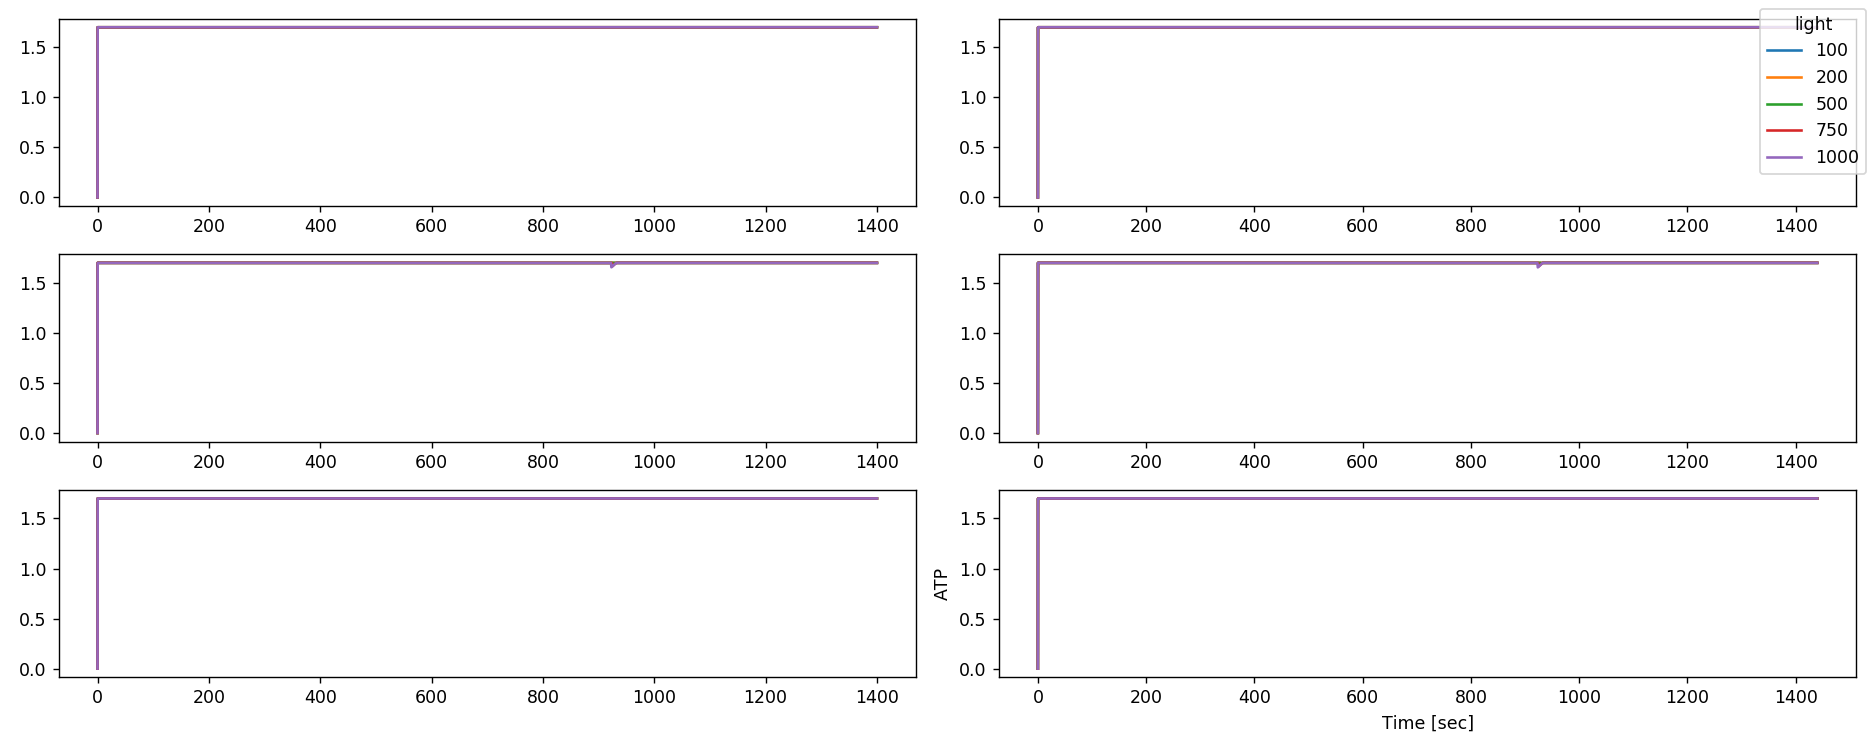

In [29]:
fig, axs = plt.subplots(3,2, figsize=(15, 6), facecolor='w', edgecolor='k')

j = 0
cnt = 0
for i in light_intens: # this is more flexible. If I tell you to include mor elight inetnsities, you just need to ammend the light list
    axs[j][0].plot(y['State1'][i]['t'],y['State1'][i]['ATP'], label=i)
    axs[+1][0].plot(y['State2'][i]['t'],y['State2'][i]['ATP'])
    axs[j+2][0].plot(y['StateNPQ'][i]['t'],y['StateNPQ'][i]['ATP'])
    
    axs[j][1].plot(yPAM['State1'][i]['t'],yPAM['State1'][i]['ATP'])
    axs[j+1][1].plot(yPAM['State2'][i]['t'],yPAM['State2'][i]['ATP'])
    axs[j+2][1].plot(yPAM['StateNPQ'][i]['t'],yPAM['StateNPQ'][i]['ATP'])
    cnt += 1

fig.legend(title='light')#, ncol=3) # add the title to your legend and you can always play with number fo columns if you want to
plt.xlabel("Time [sec]")
plt.ylabel("ATP")
fig.tight_layout()